# NYPD Borough Call Demand EDA - Manhattan

In [2]:
import pandas as pd
import numpy as mp
import matplotlib.pyplot as plt
import seaborn as sns 
import os

os.getcwd()

'/Users/dirkhartog/Desktop/CUNY_MSDS/DATA_698/py_Notebooks'

In [3]:
# Load dataframe
manhattan = pd.read_csv('/Users/dirkhartog/Desktop/CUNY_MSDS/DATA_698/Data/df_manhattan.csv',
                        parse_dates = ["incident_time", "incident_date"],
                       dtype = {"response_time_mins" : "float64"})

/var/folders/85/mb8f618d7fg208txtk5n8ddc0000gn/T/ipykernel_2831/718490622.py:2: DtypeWarning: Columns (10,14) have mixed types. Specify dtype option on import or set low_memory=False.
  manhattan = pd.read_csv('/Users/dirkhartog/Desktop/CUNY_MSDS/DATA_698/Data/df_manhattan.csv',


In [6]:
manhattan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6989070 entries, 0 to 6989069
Data columns (total 20 columns):
 #   Column              Dtype         
---  ------              -----         
 0   cad_evnt_id         int64         
 1   create_date         object        
 2   incident_date       datetime64[ns]
 3   incident_time       datetime64[ns]
 4   nypd_pct_cd         float64       
 5   boro_nm             object        
 6   patrl_boro_nm       object        
 7   typ_desc            object        
 8   cip_jobs            object        
 9   disp_ts             object        
 10  arrivd_ts           object        
 11  closng_ts           object        
 12  location            object        
 13  year                int64         
 14  response_time       object        
 15  response_time_mins  float64       
 16  hour                int64         
 17  day                 object        
 18  day_num             int64         
 19  coordinates         object        
dtypes:

In [8]:
# Sort values in chronological order
manhattan.sort_values(["incident_date","incident_time"], ascending = True, inplace = True)

In [9]:
# Find number of missing values in each variable 

manhattan.isna().sum()

cad_evnt_id                 0
create_date                 0
incident_date               0
incident_time               0
nypd_pct_cd                 0
boro_nm                     0
patrl_boro_nm               0
typ_desc                    0
cip_jobs                    0
disp_ts                     1
arrivd_ts             3096151
closng_ts                  46
location                    0
year                        0
response_time         3096151
response_time_mins    3096151
hour                        0
day                         0
day_num                     0
coordinates                 0
dtype: int64

As we saw in the EDA on the entire data there are few arrival times listed for the year 2022. This varibale will not be used in the predcitive models as the call demand volume is the target variable. 

In [13]:
# Is the creation_date and incident date the same 

sum(manhattan["create_date"] == manhattan["incident_date"]) / 6989070

0.9998962665991327

The creation date and recorded incident date are the same in approximately 100% of cases. 

The **incident date** will be the reference in determining the date and time of the recorded call. 

## Precintcts 'nypd_pct_cd'

In [16]:
# How many precincts have responsed to calls in manhattan: nypd_pct_cd

manhattan["nypd_pct_cd"].nunique()

22

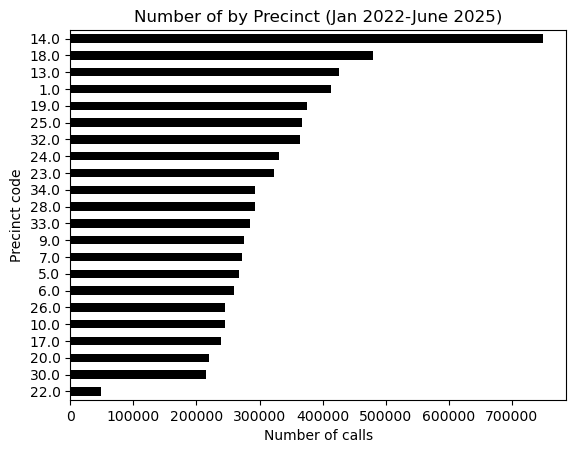

In [228]:
# Proportion of calls that were dispatched to each precinct?
manhattan["nypd_pct_cd"].value_counts(sort = True, ascending = True).plot(kind = "barh", color = "black")
plt.title("Number of by Precinct (Jan 2022-June 2025)", size = 12)
plt.ylabel("Precinct code")
plt.xlabel("Number of calls")
plt.show()

**Additional plots/graphs to visualize**
- The number of different CIP types in each precinct (Is there any obvious differences between precincts
    - Dynamic visualizatoin in shiny app
    - 2 x 2 Multiple chart Heatmap across the precincts for each CIP type

## Temporal EDA P1

### **Questions**

1. Is the data complete
    - For each year (365/366 days)
    - Within each day (24 hours)
    - **Both are important to look at trends and being able to compare years, monthly averages, hourly averages)**

2. Does this hold for each Precinct 
    - Important if separate models are going to be built for each individual precinct. 

3. Does this hold when stratified by precint and CIP type
    - Are we forecasting ALL calls or only ones that require a police officer to be dispatched.
        - From the data, how do we know if a cop is being dispatched (if an arrive time is recorded?)
    - If only looking at the two most critical call types (Serious and Critical) is there enough data?
    

In [29]:
# Create a new column date_time that combines the incident date and the hour.
from datetime import datetime

date_time_list = []

for i, row in manhattan.iterrows():
    date = row["incident_date"]
    date_stirng = date.strftime("%Y-%m-%d")
    hour = str(row["hour"]) + ":00:00"
    # Convert
    date_time = date_stirng + " " + hour
    date_time_list.append(date_time)
    

In [31]:
date_time_list[0:5]

['2022-01-01 0:00:00',
 '2022-01-01 0:00:00',
 '2022-01-01 0:00:00',
 '2022-01-01 0:00:00',
 '2022-01-01 0:00:00']

To assess the completeness of the data across all levels a new column is created called `date_time` that will combine the date and hour. This will help in validating how many calls occured in each day. 

In [34]:
manhattan["date_time"] = date_time_list
manhattan["date_time"] = pd.to_datetime(manhattan["date_time"])

#### Check year 
- Does 2022,2023,2024 contain 365/366 days

In [36]:
# Create a daily call count by year

daily_counts = manhattan.groupby("year", as_index = False, )["incident_date"].value_counts().sort_values(["year", "incident_date"], ascending = True)
daily_counts.head()

,year,incident_date,count
358,2022,2022-01-01,4618
362,2022,2022-01-02,4293
355,2022,2022-01-03,4736
344,2022,2022-01-04,4918
340,2022,2022-01-05,4935


In [39]:
# Validate that there is data for each day in the calendar year 
daily_counts.groupby("year")["incident_date"].count()

year
2022    365
2023    365
2024    366
2025    181
Name: incident_date, dtype: int64

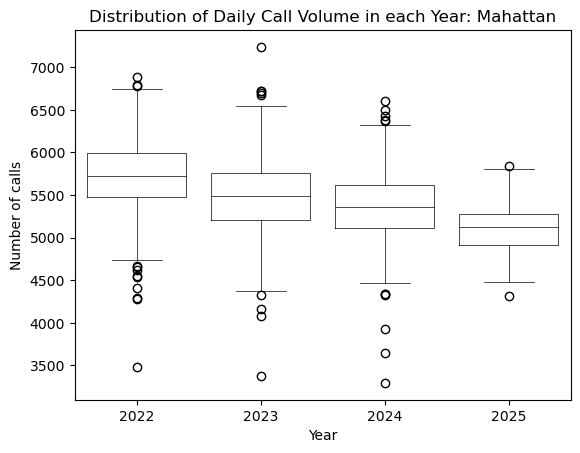

In [266]:
# Look at the distribution of call demand in each year 

sns.boxplot(data = daily_counts, x = "year", y = "count", 
            fill = False, 
            color = "black",
           linewidth = 0.5)
plt.title("Distribution of Daily Call Volume in each Year: Mahattan")
plt.xlabel("Year")
plt.ylabel("Number of calls")
plt.show()

In [43]:
# The number of calls in each year

daily_counts["year"].value_counts(sort = True)

year
2024    366
2022    365
2023    365
2025    181
Name: count, dtype: int64

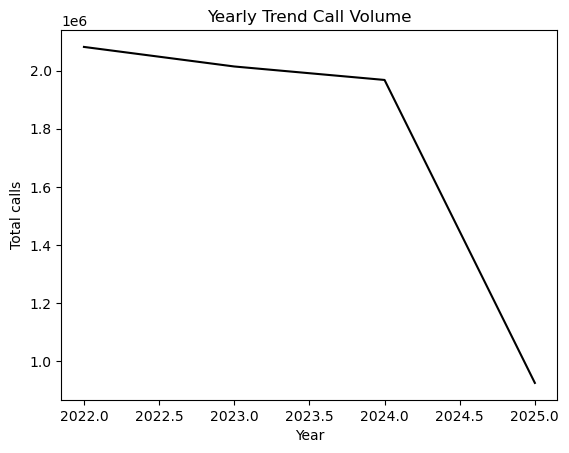

In [279]:
# View total calls each year 
sns.lineplot(data = daily_counts.groupby("year", as_index = False)["count"].sum(),
             x = "year", y = "count", color = "black")
plt.title("Yearly Trend Call Volume")
plt.xlabel("Year")
plt.ylabel("Total calls (millions_")
plt.show()

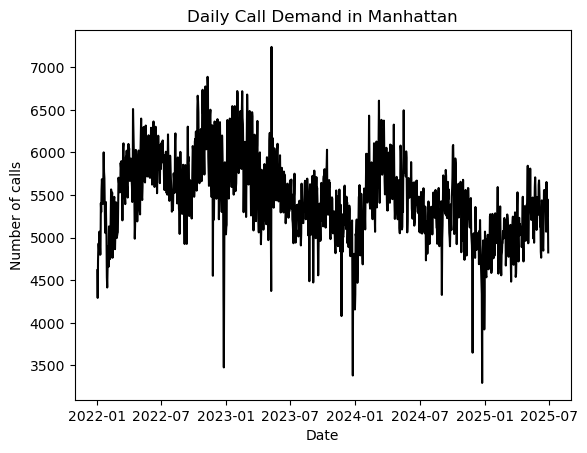

In [269]:
# Plot the daily call demand

sns.lineplot(data = daily_counts, x = "incident_date", y = "count", color = "black")
plt.title("Daily Call Demand in Manhattan")
plt.xlabel("Date")
plt.ylabel("Number of calls")
plt.show()

Each year of data contains recorded observations for all possible days in that year, except 2025 (where data is incomplete). In the sccuessive boxplots we can see a downward trend in total daily call volume. Looking at the time series plot we see some large spikes, that appear to happen at equal intervals. There is one large up tick in 2023, which is the largest outlier in the data set. 

#### Check day (hour completeness)

- Does each hour in a day have at least one call

In [49]:
# View the number of days that does not have 24 unique hours in the day 

print(f'Number of days with < 24 hours of data: {sum(manhattan.groupby("incident_date")["hour"].nunique() < 24)}')


Number of days with < 24 hours of data: 4


In [51]:
# Count the number of hours in each date

hour_counts = manhattan.groupby("incident_date", as_index = False)["hour"].nunique()
hour_counts.head()

,incident_date,hour
0,2022-01-01,24
1,2022-01-02,24
2,2022-01-03,24
3,2022-01-04,24
4,2022-01-05,24


In [53]:
# Find the dates with less than 24 hours 

print(hour_counts[hour_counts["hour"] < 24])
dates_with_missing_hours = list(hour_counts[hour_counts["hour"] < 24]["incident_date"])

     incident_date  hour
71      2022-03-13    23
435     2023-03-12    23
799     2024-03-10    23
1163    2025-03-09    23


When aggregating the call demand by days, all days contain at least one call during each hour of the day. The days that do not have 24 hours are Daylight savings time that occurs at 2 AM when the clocks move forward an hour. 

1. Check the number of days a call was recorded in each precinct by year

In [57]:
day_counts_precinct = manhattan.groupby(["nypd_pct_cd", "year"], 
                                          as_index = False).agg(num_days = ("incident_date","nunique"))
day_counts_precinct.head()

,nypd_pct_cd,year,num_days
0,1.0,2022,365
1,1.0,2023,365
2,1.0,2024,366
3,1.0,2025,181
4,5.0,2022,365


In [59]:
# Find the precincts that did not have a full years worth of recorded calls

day_counts_precinct[day_counts_precinct["num_days"] < 365]

,nypd_pct_cd,year,num_days
3,1.0,2025,181
7,5.0,2025,181
11,6.0,2025,181
15,7.0,2025,181
19,9.0,2025,181
23,10.0,2025,181
27,13.0,2025,181
31,14.0,2025,181
35,17.0,2025,181
39,18.0,2025,181


All precincts have recorded at least 1 call in 2022, 2023, 2024 and for the available data in 2025

2. Check if each precinct recorded a call in each hour of the day 

In [63]:
hour_counts_precinct = manhattan.groupby(["nypd_pct_cd","incident_date"], 
                                                as_index = False).agg(num_hours = ("hour","nunique"))

In [64]:
hour_counts_precinct.head()

,nypd_pct_cd,incident_date,num_hours
0,1.0,2022-01-01,24
1,1.0,2022-01-02,24
2,1.0,2022-01-03,24
3,1.0,2022-01-04,24
4,1.0,2022-01-05,24


In [67]:
hour_counts_precinct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28094 entries, 0 to 28093
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   nypd_pct_cd    28094 non-null  float64       
 1   incident_date  28094 non-null  datetime64[ns]
 2   num_hours      28094 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 658.6 KB


In [69]:
# filter out the days a precinct recorded calls for less than 24 hours that is not daylight savings 

hour_counts_precinct[(hour_counts_precinct["num_hours"] < 24) & 
                           (~hour_counts_precinct["incident_date"].isin(dates_with_missing_hours))]

,nypd_pct_cd,incident_date,num_hours
249,1.0,2022-09-07,23
384,1.0,2023-01-20,23
600,1.0,2023-08-24,23
614,1.0,2023-09-07,23
625,1.0,2023-09-18,23
...,...,...,...
28000,34.0,2025-03-29,23
28034,34.0,2025-05-02,23
28061,34.0,2025-05-29,23
28064,34.0,2025-06-01,23


## Visualizations 

### Month

In [72]:
# Create a new column called month
manhattan["month"] = manhattan["incident_date"].dt.month

monthly_counts = manhattan.groupby("year", as_index = False, )["month"].value_counts().sort_values(["year", "month"], ascending = True)
monthly_counts.head()

,year,month,count
10,2022,1,159188
11,2022,2,143612
5,2022,3,177700
8,2022,4,171532
1,2022,5,182697


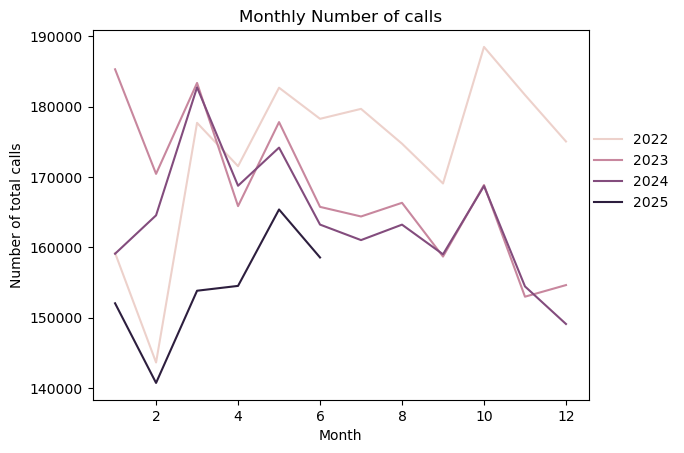

In [73]:
sns.lineplot(data = monthly_counts, x = "month", y = "count", hue = "year")
plt.title("Monthly Number of calls")
plt.xlabel("Month")
plt.ylabel("Number of total calls")
plt.legend(loc = (1, 0.5), frameon = False)
plt.show()

In [77]:
# Heat map of the average calls in each month over the past three years by precinct

monthly_counts_precinct = manhattan[manhattan["year"].isin([2022,2023,2024])].groupby(["nypd_pct_cd", "month"], as_index = False).agg(count = ("incident_date","count"))
monthly_counts_precinct["avg_calls"] = monthly_counts_precinct["count"] / 3

monthly_counts_precinct.head()

,nypd_pct_cd,month,count,avg_calls
0,1.0,1,30396,10132.000000
1,1.0,2,30005,10001.666667
2,1.0,3,32960,10986.666667
3,1.0,4,29404,9801.333333
4,1.0,5,30644,10214.666667


In [78]:
# Pivot table to put into heat map 

monthly_counts_precinct_pivoted = monthly_counts_precinct.pivot_table(values = "avg_calls", index = "nypd_pct_cd", columns = "month")

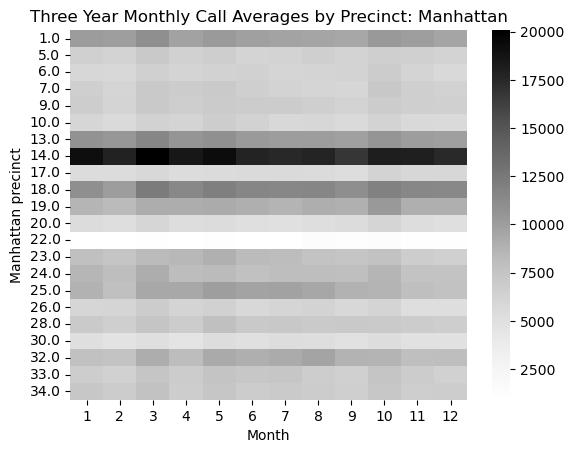

In [264]:
sns.heatmap(monthly_counts_precinct_pivoted, cmap = "Greys")
plt.title("Three Year Monthly Call Averages by Precinct: Manhattan")
plt.xlabel("Month")
plt.ylabel("Manhattan precinct")
plt.show()

The *22nd* precinct is central park

The *14th* precinct consists of neighborhoods Midtown, Theater district, Herald Square.

### Daily

Investigate the daily counts for each precinct

In [88]:
precinct_daily_counts = manhattan.groupby(["nypd_pct_cd", "incident_date"], 
                                          as_index = False).agg(counts = ("incident_date","count"))
precinct_daily_counts.head()

,nypd_pct_cd,incident_date,counts
0,1.0,2022-01-01,289
1,1.0,2022-01-02,276
2,1.0,2022-01-03,298
3,1.0,2022-01-04,330
4,1.0,2022-01-05,353


In [239]:
precinct_daily_counts["week_day"] = precinct_daily_counts["incident_date"].dt.weekday
precinct_daily_counts["year"] = precinct_daily_counts["incident_date"].dt.year

precinct_daily_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28094 entries, 0 to 28093
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   nypd_pct_cd    28094 non-null  float64       
 1   incident_date  28094 non-null  datetime64[ns]
 2   counts         28094 non-null  int64         
 3   year           28094 non-null  int32         
 4   week_day       28094 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(1)
memory usage: 878.1 KB


In [260]:
# Calculate average counts 
data = precinct_daily_counts.groupby(["year", "week_day"], as_index= False).agg(avg_count = ("counts", "mean"))
data.head()

,year,week_day,avg_count
0,2022,0,247.187063
1,2022,1,268.193182
2,2022,2,272.222028
3,2022,3,267.177448
4,2022,4,263.729895


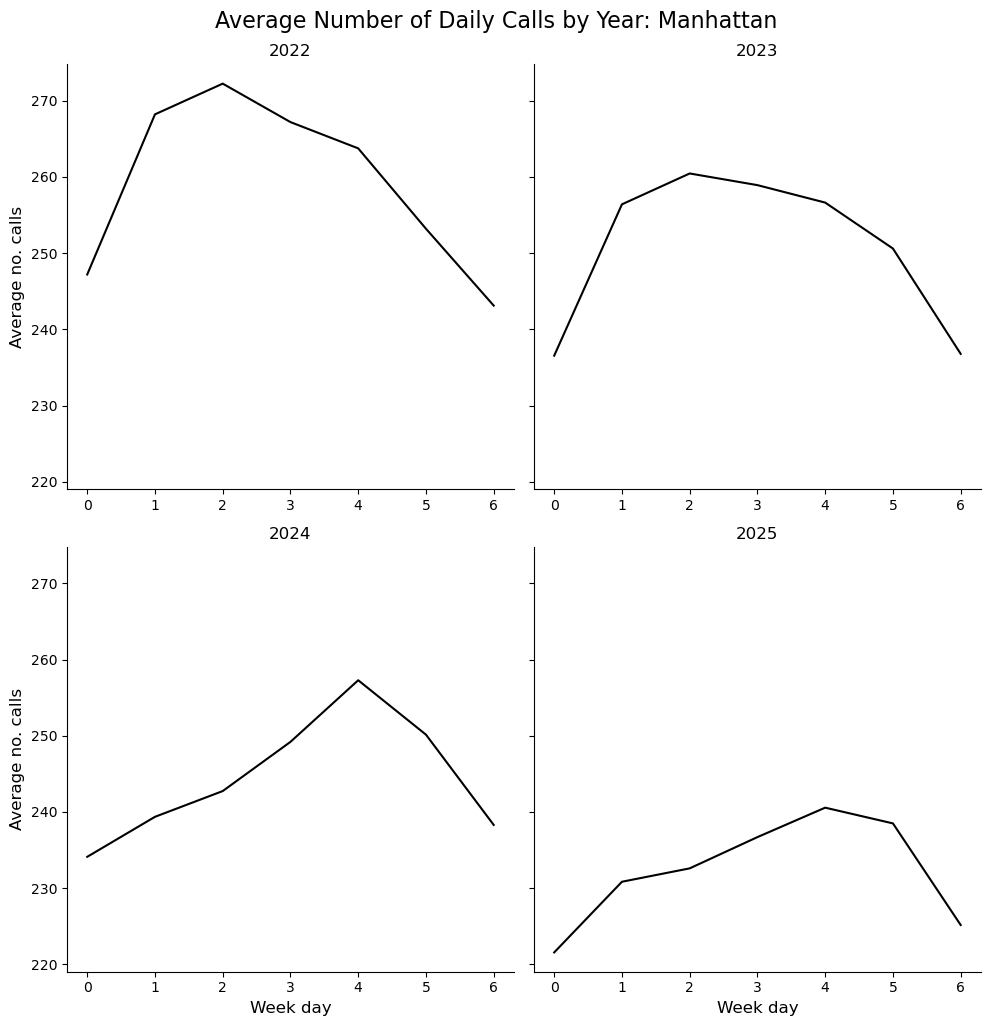

In [262]:
a = sns.relplot(data = data, 
            x = "week_day", y = "avg_count", 
            col= "year", 
            kind = "line",
            col_wrap = 2,
            facet_kws={'sharex': False, 'sharey': True},
            color = "black")

plt.suptitle("Average Number of Daily Calls by Year: Manhattan", 
             y = 1.02, 
             size = 16)

a.set_titles(col_template="{col_name}", 
             size = 12)

a.set_ylabels("Average no. calls", size = 12)
a.set_xlabels("Week day", size = 12)

plt.show()

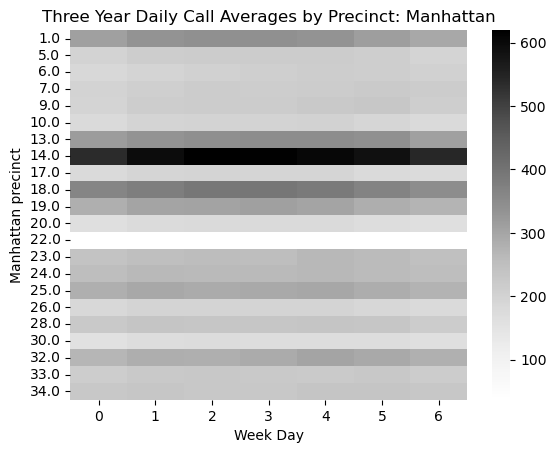

In [272]:
data = precinct_daily_counts.groupby(["nypd_pct_cd", "week_day"], as_index= False).agg(avg_count = ("counts", "mean"))
data = data.pivot_table(values = "avg_count", index = "nypd_pct_cd", columns = "week_day")

sns.heatmap(data, cmap = "Greys")
plt.title("Three Year Daily Call Averages by Precinct: Manhattan", size = 12)
plt.xlabel("Week Day")
plt.ylabel("Manhattan precinct")
plt.show()

### Daily Call Type

In [174]:
precinct_daily_counts_ciptype = manhattan.groupby(['nypd_pct_cd', 'incident_date', 'cip_jobs'], 
                                                 as_index = False).agg(counts = ("incident_date", "count"))

In [176]:
precinct_daily_counts_ciptype.head()

,nypd_pct_cd,incident_date,cip_jobs,counts
0,1.0,2022-01-01,Critical,2
1,1.0,2022-01-01,Non CIP,278
2,1.0,2022-01-01,Non Critical,3
3,1.0,2022-01-01,Serious,6
4,1.0,2022-01-02,Critical,3


In [252]:
data = precinct_daily_counts_ciptype.groupby(["nypd_pct_cd", "incident_date"], 
                                      as_index = False).agg(num_call_types = ("cip_jobs", "count"))

data.shape

(28094, 3)

In [254]:
data[data["num_call_types"] < 4].shape

(6973, 3)

In [257]:
# Get the number of unique precincts 
data[data["num_call_types"] < 4]["nypd_pct_cd"].nunique()

22

In [84]:
total_hourly_call_counts = manhattan.groupby(["year", "date_time"], as_index = False)["incident_date"].count()
total_hourly_call_counts.head()

,year,date_time,incident_date
0,2022,2022-01-01 00:00:00,240
1,2022,2022-01-01 01:00:00,238
2,2022,2022-01-01 02:00:00,234
3,2022,2022-01-01 03:00:00,167
4,2022,2022-01-01 04:00:00,131


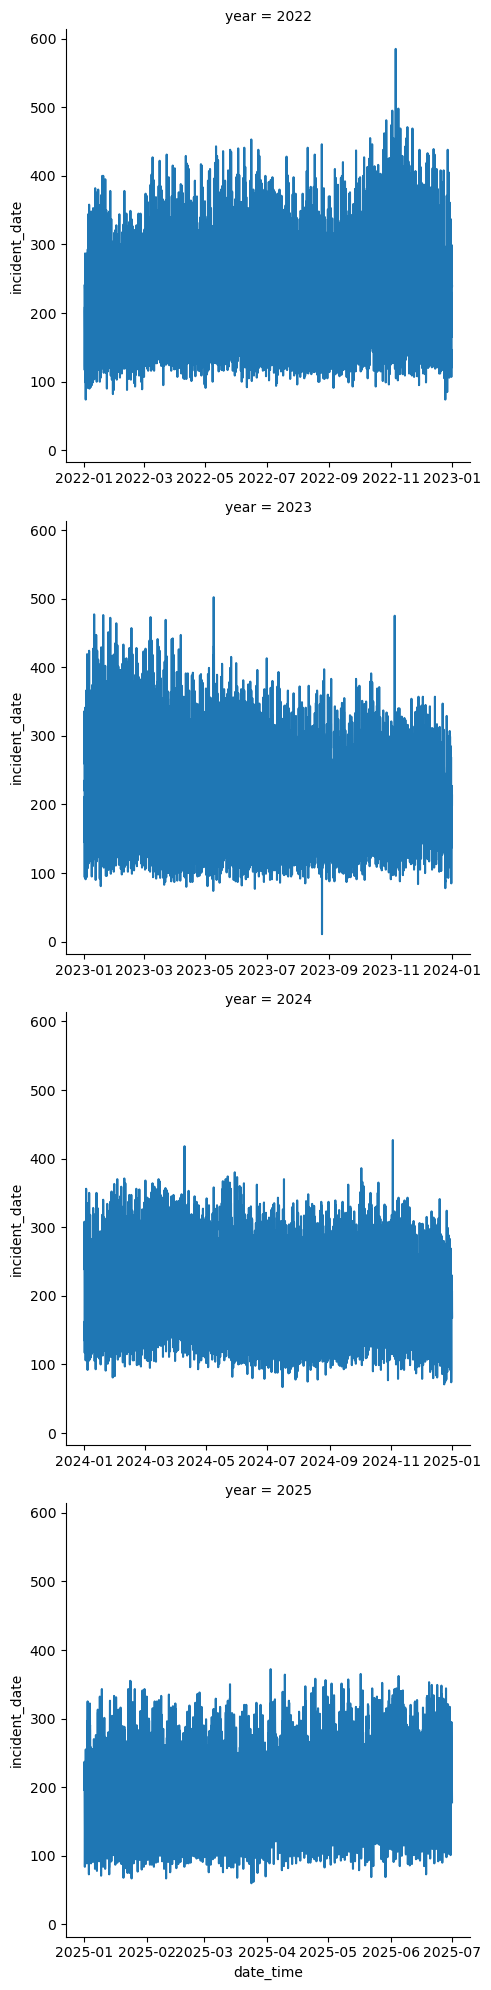

In [110]:
sns.relplot(data = total_hourly_call_counts, 
            x = "date_time", y = "incident_date", row= "year", kind = "line",
           facet_kws={'sharex': False, 'sharey': True})
plt.show()

## Response Time 

In [22]:
# Get descriptive stats for each type of call
manhattan["response_time_mins"] = manhattan["response_time_mins"].astype("float64")
manhattan.groupby("cip_jobs")["response_time_mins"].describe()

,count,mean,std,min,25%,50%,75%,max
cip_jobs,,,,,,,,
Critical,35861.0,4.457177,10.253561,0.000000,1.116667,2.316667,4.233333,325.316667
Non CIP,3613611.0,9.259814,32.162563,-54.700000,0.000000,0.000000,1.733333,1470.583333
Non Critical,139696.0,13.002174,25.916701,-54.333333,2.183333,5.516667,12.783333,725.950000
Serious,103751.0,7.585889,15.264258,0.000000,1.983333,3.950000,7.566667,1047.383333


## Sample Time Series Analysis

In [139]:
precinct1 = precinct_daily_counts[precinct_daily_counts["nypd_pct_cd"] == 1]
precinct1.head()

,nypd_pct_cd,incident_date,counts
0,1.0,2022-01-01,289
1,1.0,2022-01-02,276
2,1.0,2022-01-03,298
3,1.0,2022-01-04,330
4,1.0,2022-01-05,353


In [141]:
precinct1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1277 entries, 0 to 1276
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   nypd_pct_cd    1277 non-null   float64       
 1   incident_date  1277 non-null   datetime64[ns]
 2   counts         1277 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 39.9 KB


## Construct Data Frames for forecasting

Dataframes
- `precinct_daily_counts`
- `precinct_hourly_counts`
- `precinct_daily_counts_ciptype`
- `precinct_hourly_counts_ciptype`

In [322]:
manhattan.columns

Index(['cad_evnt_id', 'create_date', 'incident_date', 'incident_time',
       'nypd_pct_cd', 'boro_nm', 'patrl_boro_nm', 'typ_desc', 'cip_jobs',
       'disp_ts', 'arrivd_ts', 'closng_ts', 'location', 'year',
       'response_time', 'response_time_mins', 'hour', 'day', 'day_num',
       'coordinates', 'date_time', 'month'],
      dtype='object')

In [341]:
# Create hourly data frames 
precinct_daily_counts = manhattan.groupby(["nypd_pct_cd", "incident_date"], 
                                          as_index = False).agg(counts = ("incident_date","count"))
precinct_daily_counts_ciptype = manhattan.groupby(['nypd_pct_cd', 'incident_date', 'cip_jobs'], 
                                                 as_index = False).agg(counts = ("incident_date", "count"))
precinct_hourly_counts_ciptype = manhattan.groupby(['nypd_pct_cd', 'date_time', 'cip_jobs'], 
                                                 as_index = False).agg(counts = ("incident_date", "count"))
precinct_hourly_counts = manhattan.groupby(['nypd_pct_cd', 'date_time'], 
                                                 as_index = False).agg(counts = ("incident_date", "count"))

In [443]:
os.getcwd()

'/Users/dirkhartog/Desktop/CUNY_MSDS/DATA_698'

In [452]:
# Save Data frames

precinct_daily_counts_ciptype.to_csv('/Users/dirkhartog/Desktop/CUNY_MSDS/DATA_698/Data/manhattan/manhattan_dailyCIP_counts.csv',
                                    index=False)
precinct_hourly_counts_ciptype.to_csv('/Users/dirkhartog/Desktop/CUNY_MSDS/DATA_698/Data/manhattan/manhattan_hourlyCIP_counts.csv',
                                    index=False)
precinct_hourly_counts.to_csv('/Users/dirkhartog/Desktop/CUNY_MSDS/DATA_698/Data/manhattan/manhattan_hourly_counts.csv',
                              index=False)
precinct_daily_counts.to_csv('/Users/dirkhartog/Desktop/CUNY_MSDS/DATA_698/Data/manhattan/manhattan_daily_counts.csv', 
                             index=False)